## Observational social learning task with a basic working-memory-based network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd

### Task is defined by the Environment node

In [2]:
class Environment():
    def __init__(self, sid, trial, time_sample=2, dt=0.001, weight_mode='default'):
        self.time_sample = time_sample
        self.dt = dt
        self.sid = sid
        self.trial = trial
        self.empirical = pd.read_pickle(f"data/behavior.pkl").query("sid==@sid & trial==@trial")
        self.weight_mode = weight_mode
        self.color = 0
        self.weight = 0
        self.inhibit1 = 0
        self.inhibit2 = 0
        self.stage = 0
        self.n_neighbors = len(self.empirical['who'].unique()) - 1
        # create input arrays
        self.colors = []
        self.weights = []
        self.n_samples = []
        self.inhibit1s = []
        self.inhibit2s = []
        tt = int(self.time_sample / self.dt)
        tt2 = int(tt/2)
        self.T = self.time_sample + 3*self.n_neighbors*self.time_sample - self.dt
        for stage in range(4):
            if stage==0:
                color = self.empirical.query("stage==@stage")['color'].to_numpy()[0]
                n_samples = 1
                if self.weight_mode=='default':
                    weight = 1 / n_samples
                self.colors.extend(2*color-1 * np.ones((tt, 1)))
                self.weights.extend(weight * np.ones((tt, 1)))
                self.n_samples.extend(n_samples * np.ones((tt, 1)))
                self.inhibit1s.extend(1 * np.ones((tt2, 1)))
                self.inhibit2s.extend(0 * np.ones((tt2, 1)))
                self.inhibit1s.extend(0 * np.ones((tt2, 1)))
                self.inhibit2s.extend(1 * np.ones((tt2, 1)))
            else:
                for n in range(self.n_neighbors):
                    color = self.empirical.query("stage==@stage")['color'].to_numpy()[n]
                    # weight = self.empirical.query("stage==@stage")['RD'].to_numpy()[n]
                    # weight = 1
                    n_samples = 1 + (stage-1)*self.n_neighbors + (n+1)
                    if self.weight_mode=='default':
                        weight = 1 / n_samples
                    self.colors.extend(2*color-1 * np.ones((tt, 1)))
                    self.weights.extend(weight * np.ones((tt, 1)))
                    self.n_samples.extend(n_samples * np.ones((tt, 1)))
                    self.inhibit1s.extend(1 * np.ones((tt2, 1)))
                    self.inhibit2s.extend(0 * np.ones((tt2, 1)))
                    self.inhibit1s.extend(0 * np.ones((tt2, 1)))
                    self.inhibit2s.extend(1 * np.ones((tt2, 1)))
        self.colors = np.array(self.colors).flatten()
        self.weights = np.array(self.weights).flatten()
        self.n_samples = np.array(self.n_samples).flatten()
        self.inhibit1s = np.array(self.inhibit1s).flatten()
        self.inhibit2s = np.array(self.inhibit2s).flatten()
                    
    def sample(self, t):
        tidx = int(t/self.dt)
        return [self.colors[tidx], self.weights[tidx], self.inhibit1s[tidx], self.inhibit2s[tidx]]

   sid  trial  network  stage  who  color  degree       RD  action
0    1      1        9      0    2      1       3  0.00000       1
1    1      1        9      1    6      0       3  0.23077       1
2    1      1        9      1    5      0       3  0.23077       1
3    1      1        9      1    7      1       4  0.30769       1
4    1      1        9      2    5      0       3  0.23077       0
5    1      1        9      2    7      1       4  0.30769       0
6    1      1        9      2    6      0       3  0.23077       0
7    1      1        9      3    7      0       4  0.30769       0
8    1      1        9      3    6      0       3  0.23077       0
9    1      1        9      3    5      0       3  0.23077       0


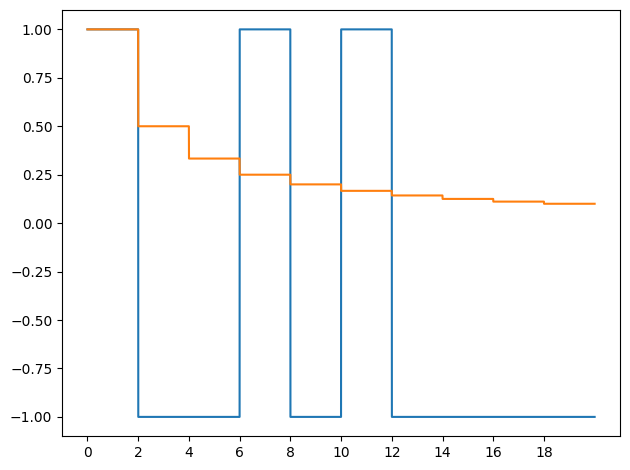

In [3]:
## Check Environment inputs
env = Environment(sid=1, trial=1, time_sample=2)
print(env.empirical)
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.colors)
ax.plot(np.arange(0, env.T+env.dt, env.dt), env.weights)
# ax.plot(np.arange(0, env.T+env.dt, env.dt), env.n_samples)
ax.set(xticks = np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()
plt.show()

### Define the neural network

In [4]:
def build_network(env, n_neurons=500, seed_net=0, syn_feedback=0.1):
    net = nengo.Network(seed=seed_net)
    func_obs = lambda t: env.sample(t)[0]
    func_weight = lambda t: env.sample(t)[1]
    func_inh1 = lambda t: env.sample(t)[2]
    func_inh2 = lambda t: env.sample(t)[3]
    func_load = lambda x: (x[0] - x[1]) * x[2]
    func_diff = lambda x: (x[0] - x[1])
    func_choice = lambda x: -1 if x[0] < 0 else 1

    with net:
        # external inputs
        net.input_obs = nengo.Node(func_obs)
        net.input_weight = nengo.Node(func_weight)
        net.inhibit1 = nengo.Node(func_inh1)
        net.inhibit2 = nengo.Node(func_inh2)
        # ensembles
        net.obs = nengo.Ensemble(n_neurons, 1)
        net.weight = nengo.Ensemble(n_neurons, 1)
        net.combined = nengo.Ensemble(3*n_neurons, 3, radius=3)
        net.memory = nengo.Ensemble(n_neurons, 1)
        net.temp = nengo.Ensemble(n_neurons, 2)
        net.old = nengo.Ensemble(n_neurons, 1)
        net.decision = nengo.Ensemble(n_neurons, 1)
        # connections
        nengo.Connection(net.input_obs, net.obs)
        nengo.Connection(net.input_weight, net.weight)
        nengo.Connection(net.obs, net.combined[0])
        nengo.Connection(net.old, net.combined[1])
        nengo.Connection(net.weight, net.combined[2])
        nengo.Connection(net.combined, net.memory, function=func_load, transform=syn_feedback)
        nengo.Connection(net.memory, net.memory, synapse=syn_feedback)
        nengo.Connection(net.memory, net.temp[0])
        nengo.Connection(net.old, net.temp[1])
        nengo.Connection(net.temp, net.old, function=func_diff)
        nengo.Connection(net.old, net.old, synapse=syn_feedback)
        nengo.Connection(net.inhibit1, net.temp.neurons, transform=-1e3*np.ones((net.temp.n_neurons, 1)))
        nengo.Connection(net.inhibit2, net.combined.neurons, transform=-1e3*np.ones((net.combined.n_neurons, 1)))
        nengo.Connection(net.memory, net.decision, function=func_choice)
        # probes
        net.probe_input = nengo.Probe(net.input_obs, synapse=0.01)
        net.probe_obs = nengo.Probe(net.obs, synapse=0.01)
        net.probe_weight = nengo.Probe(net.weight, synapse=0.01)
        net.probe_memory = nengo.Probe(net.memory, synapse=0.01)
        net.probe_old = nengo.Probe(net.old, synapse=0.01)
        net.probe_decision = nengo.Probe(net.decision, synapse=0.01)
    return net

### Simulate the network for one observation

In [5]:
def simulate(sid, trial, seed_sim=0):
    env = Environment(sid, trial)
    net = build_network(env)
    sim = nengo.Simulator(net, seed=seed_sim)
    with sim:
        sim.run(env.T)
    return net, sim

## Experiment 1

In [6]:
net, sim = simulate(sid=1, trial=2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

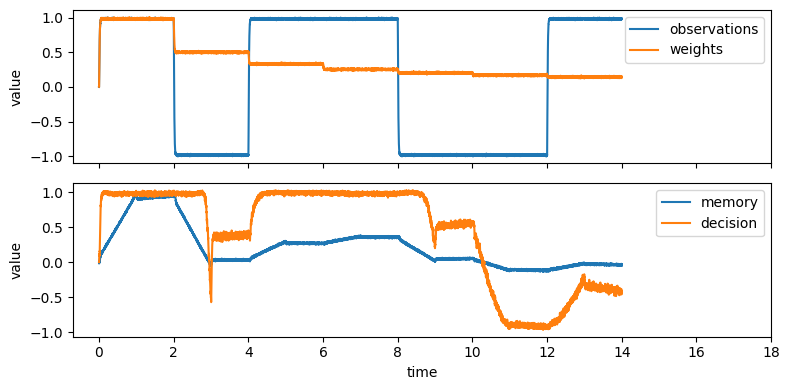

In [7]:
times = sim.trange().flatten()
input_obs = sim.data[net.probe_input].flatten()
obs = sim.data[net.probe_obs].flatten()
weights = sim.data[net.probe_weight].flatten()
mem = sim.data[net.probe_memory].flatten()
old = sim.data[net.probe_old].flatten()
decision = sim.data[net.probe_decision][:,0].flatten()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,4), sharex=True)
# sns.lineplot(x=times, y=input_obs, ax=ax, label='true observations', color='k')
sns.lineplot(x=times, y=obs, ax=axes[0], label='observations')
sns.lineplot(x=times, y=weights, ax=axes[0], label='weights')
sns.lineplot(x=times, y=mem, ax=axes[1], label='memory')
# sns.lineplot(x=times, y=old, ax=ax, label='old')
sns.lineplot(x=times, y=decision, ax=axes[1], label='decision')
# sns.lineplot(x=times, y=confidence, ax=axes[1], label='confidence')
axes[0].set(xlabel='time', ylabel='value')
axes[1].set(xlabel='time', ylabel='value', xticks=np.arange(0, env.T+env.dt, env.time_sample))
plt.tight_layout()